<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Model To Production

### Gathering Data.

In [ ]:
!pip install -Uqq fastbook
!pip install bing_image_downloader
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
from bing_image_downloader import downloader
import os, shutil
from pathlib import Path
from fastai.vision.all import *

In [ ]:
dataset_names= 'bears'
path= Path(dataset_names)

In [ ]:
if not path.exists():
  path.mkdir()

In [ ]:
labels = ['grizzly', 'black', 'teddy']

In [ ]:
for l in labels:
  downloader.download(query=f'{l} bear',limit=100,output_dir=path,adult_filter_off=True)

[%] Downloading Images to /content/bears/grizzly bear


[!!]Indexing page: 1

[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly+Bear+Wildlife.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://wallsdesk.com/wp-content/uploads/2017/01/Grizzly-Bear-full-HD.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://4.bp.blogspot.com/-3WcCGQ1bzJI/UXcshw5QEwI/AAAAAAAAIns/gfJpUVE0FK8/s1600/Grizzly-Bear-7.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://thelatebloomerhiker.files.wordpress.com/2014/11/grizzly-bear-22224-1920x1200.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://cdn.britannica.com/19/186719-050-887A6F2C/Grizzly-bear-Rocky-Mountains-Wyoming.jpg
[Error]Invalid image, not saving https://cdn.britannica.com/19/186719-050-887A6F2C/Grizzly-bear-Rocky-Mountains-Wyoming.jpg

[!] Issue getting: https://cdn.britannica.com/19/186719-050-8

In [ ]:
fns = get_image_files(path)
fns

(#300) [Path('bears/grizzly bear/Image_57.jpg'),Path('bears/grizzly bear/Image_2.jpg'),Path('bears/grizzly bear/Image_9.jpg'),Path('bears/grizzly bear/Image_40.jpg'),Path('bears/grizzly bear/Image_88.jpg'),Path('bears/grizzly bear/Image_28.jpg'),Path('bears/grizzly bear/Image_98.jpg'),Path('bears/grizzly bear/Image_38.jpg'),Path('bears/grizzly bear/Image_18.jpg'),Path('bears/grizzly bear/Image_3.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
#To remove the failed images use: Unlink
failed.map(Path.unlink);

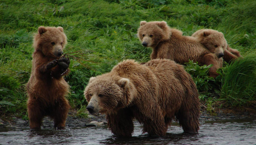

In [ ]:
#Checking the image
img = Image.open('bears/grizzly bear/Image_87.jpg')
img.thumbnail((256, 256))
img

### From Data to DataLoders

In [ ]:
#Creating DataLoaders after datablock
bears = DataBlock(
  blocks = (ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(128)
)

dls = bears.dataloaders(path)

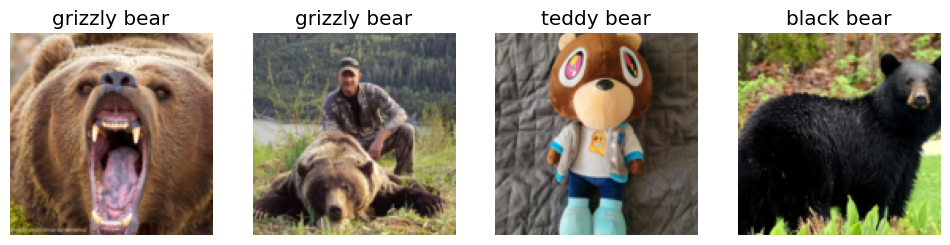

In [ ]:
# Inspecting the DataLoader:
dls.valid.show_batch(max_n=4, nrows=1)

Now asking fast ai to either stretch or squeeze the image for the image consistency during classification

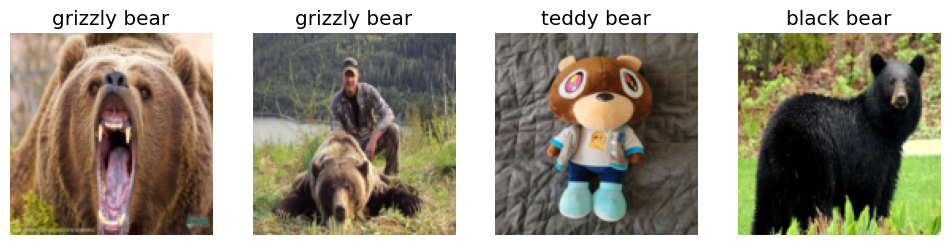

In [ ]:
#Testing various methods:
#@ 1st going for squish
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

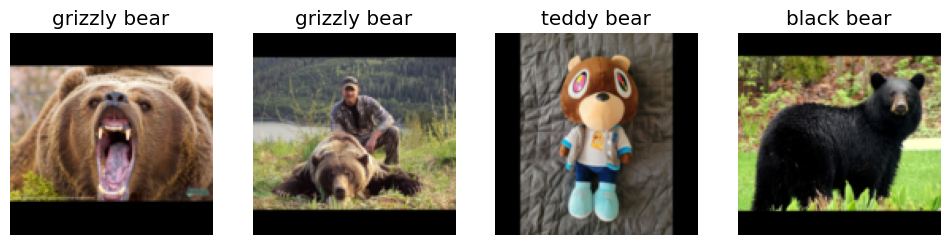

In [ ]:
#@ 2nd we pad:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode="zeros"))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

**Note:** *Above used method are the traditional methods.* Traditional image preprocessing methods can distort images or remove key features, reducing accuracy. A better approach is ***RandomResizedCrop***, which randomly selects and crops different parts of an image during training. This technique helps the model learn to recognize features despite variations in framing, aiding its understanding of objects in various positions and sizes.

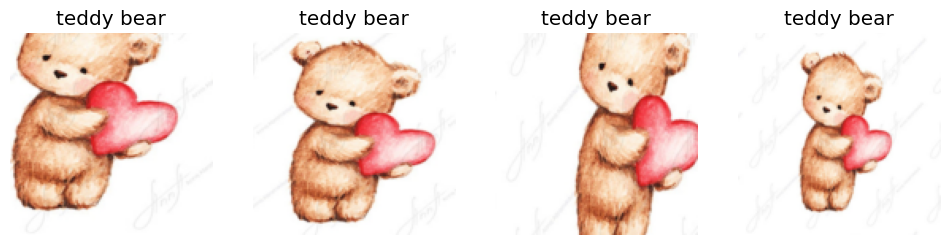

In [ ]:
#@ RandomResizedCrop:
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.3)
    )
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation:

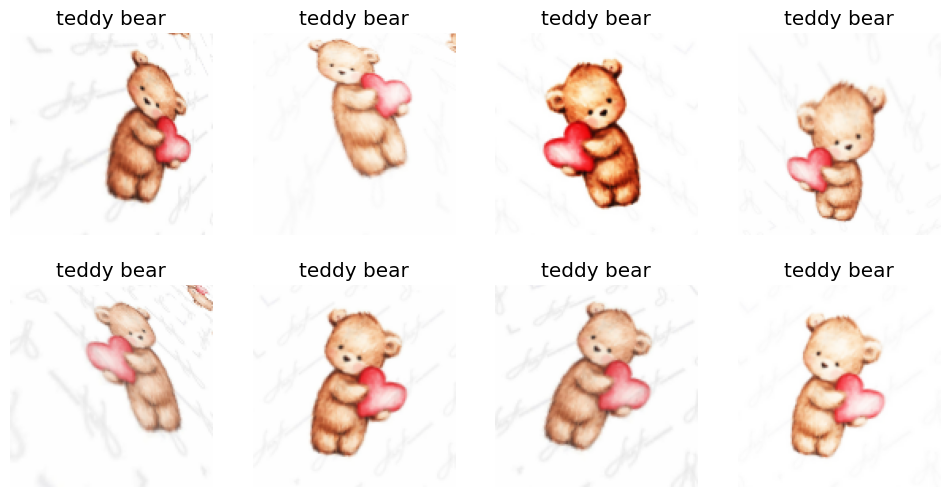

In [ ]:
# Augmenting data so that model gets more images to train on. We just transform and translate the images.
bears = bears.new(
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2)
    )
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Model Training and using it to clean the data

In [ ]:
# Creating our learner:
bears = bears.new(
 item_tfms=RandomResizedCrop(224, min_scale=0.5),
 batch_tfms=aug_transforms()
 )
dls = bears.dataloaders(path)

learn= cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


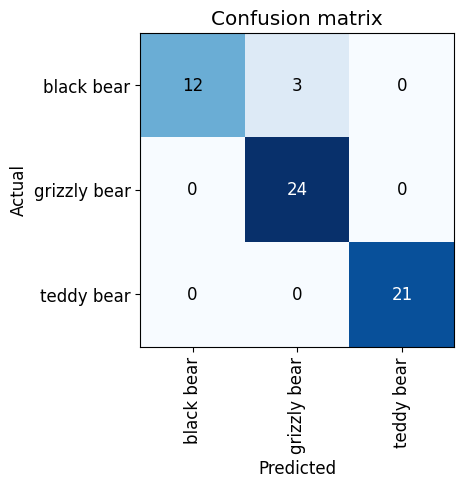

In [ ]:
# Now Looking for the Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

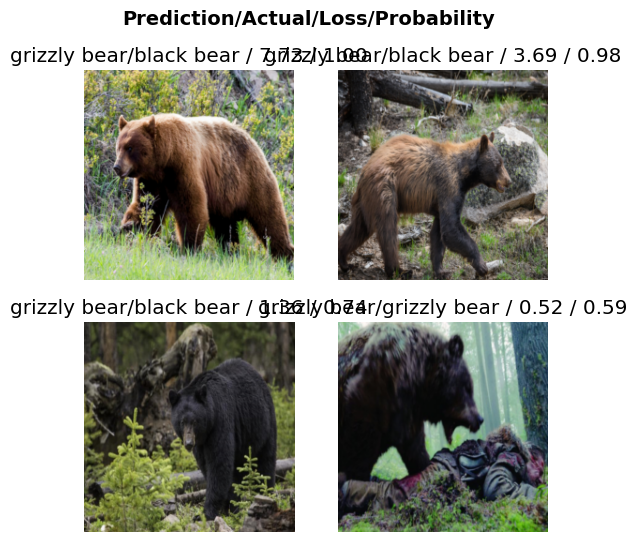

In [ ]:
# Inspecting incorrect predictions:
interp.plot_top_losses(4, nrows=2)

In [ ]:
#@ Time for Data Cleaning:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink() #@ Deleting all unrelated images which were there during training

### Model For Inference

In [ ]:
#Saving the model:
learn.export()

In [ ]:
#@ Checking the model:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

**Note:** When the model is used for getting predictions rather than training, it's called as inference. Now Creating the InferenceLearner.

In [ ]:
#@ Creating the InferenceLearner
learn_inf= load_learner(path/'export.pkl')
learn_inf.predict('bears/grizzly bear/Image_87.jpg')

('grizzly bear', tensor(1), tensor([2.0340e-07, 9.9998e-01, 1.5920e-05]))

In [ ]:
learn_inf.dls.vocab

['black bear', 'grizzly bear', 'teddy bear']

## Creating a Notebook App from the Model


In [ ]:
#@ Now we will implement the GUI components in the notebook itself.
#@ But First lets import all the widgets
from fastai.vision.widgets import *

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#@ Grabbing the image
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#@ Output widget to display
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
#@ Now we get out predictions on the image we just uploaded.
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#@ Now displaying the predictions
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy bear; Probability: 1.0000')

But what if we could also classify just by clicking on the button on notebook itself?


In [ ]:
#@ Implementing the classification button:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

Well button is created but we need to also create a function that has event_listener on the classification button.


In [ ]:
#@ Defining the function:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
 VBox([widgets.Label('Select your bear!'),
 btn_upload, btn_run, out_pl, lbl_pred])

And with this we have created the prediction model with builtin notebook GUI for easier classification.